In [1]:
import pandas as pd
import numpy as np
import argparse
import time
import pickle as pkl

from itertools import product
from functools import reduce

In [2]:
def year_binner(year,val=10):
    return year - year%val

In [3]:
parser = argparse.ArgumentParser(description='Compute features from sparse dataset')

parser.add_argument('--temporal',  type=int,
                    help='Value to bin the temporal information: 0 (remove temporal information), 1 (no binning), 10 (binning to decades), 20 (binning each 20 years) or 50 (binning each 50 years)')

parser.add_argument('--cutoff', type=int, default=50,
                    help='Cut-off frequency for each compound per time period : none (0), 20, 50 and 100')

parser.add_argument('--contextual', action='store_true',
                    help='Is the model contextual')
parser.add_argument('--inputdir',type=str,
                    help='Provide directory where features are located')
parser.add_argument('--outputdir',type=str,
                    help='Where should the output be stored?')

parser.add_argument('--tag', action='store_true',
                    help='Should the POS tag be kept?')

args = parser.parse_args('--inputdir ../datasets/compound_aware/ --contextual --temporal 10 --cutoff 10 --outputdir ../datasets/compound_aware/'.split())

In [4]:
print(f'Cutoff: {args.cutoff}')
print(f'Time span:  {args.temporal}')
temp_cutoff_str=str(args.temporal)+'_'+str(args.cutoff)

Cutoff: 10
Time span:  10


In [5]:
test_df=pd.read_csv('data/all_compounds.txt',sep='\t')
test_df

copy_df=test_df.copy()
copy_df.modifier=copy_df.modifier.str.split('_').str[0]
copy_df['head']=copy_df['head'].str.split('_').str[0]

if args.tag:
    copy_df_1=copy_df.copy()
    copy_df_1.modifier=copy_df_1.modifier+'_NOUN'
    copy_df_1['head']=copy_df_1['head']+'_NOUN'

    copy_df_2=copy_df.copy()
    copy_df_2.modifier=copy_df_2.modifier+'_PROPN'
    copy_df_2['head']=copy_df_2['head']+'_NOUN'

    copy_df_3=copy_df.copy()
    copy_df_3.modifier=copy_df_3.modifier+'_NOUN'
    copy_df_3['head']=copy_df_3['head']+'_PROPN'

    copy_df_4=copy_df.copy()
    copy_df_4.modifier=copy_df_4.modifier+'_PROPN'
    copy_df_4['head']=copy_df_4['head']+'_PROPN'


    compound_df=pd.concat([copy_df_1,copy_df_2,copy_df_3,copy_df_4],ignore_index=True)

else:
    compound_df=copy_df.copy()
    
compound_df

,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std,modifier,head
0,3.866667,1.117537,4.866667,0.339935,4.250000,0.871165,end,user
1,1.607143,1.654848,1.892857,1.496169,1.703704,1.717337,firing,line
2,2.821429,1.964935,4.862069,0.344828,3.827586,1.233693,game,plan
3,4.766667,0.422953,4.862069,0.344828,4.800000,0.476095,application,form
4,0.600000,0.800000,4.586207,1.099129,1.310345,1.020596,snail,mail
...,...,...,...,...,...,...,...,...
205,2.684200,1.492700,4.157900,1.344300,3.157900,1.344300,street,girl
206,4.736800,0.452400,4.421100,0.597300,4.631600,0.597300,subway,system
207,2.222200,1.800500,4.333300,1.757300,2.500000,1.757300,tennis,elbow
208,4.100000,1.252400,0.350000,1.394500,1.050000,1.394500,top,dog


In [6]:
modifier_list=test_df.modifier.str.split('_').str[0].unique()

if args.tag:
    modifier_list=list(product(modifier_list,['_NOUN','_PROPN']))
    modifier_list=[''.join(word) for word in modifier_list]

In [7]:
head_list=test_df['head'].str.split('_').str[0].unique()

if args.tag:
    head_list=list(product(head_list,['_NOUN','_PROPN']))
    head_list=[''.join(word) for word in head_list]

In [8]:
def read_compound():
    compounds=pd.read_pickle(args.inputdir+"/compounds_1.pkl")
        
    if not args.tag:
        compounds['head']=compounds['head'].str.replace('_NOUN|_PROPN','',regex=True)
        compounds.modifier=compounds.modifier.str.replace('_NOUN|_PROPN','',regex=True)
        
    if args.temporal==0:
        print('No temporal information is stored')
        compounds=compounds.loc[compounds.groupby(['modifier','head'],observed=True)['count'].transform('sum').gt(args.cutoff)]
        compounds=compounds.groupby(['modifier','head','context'],observed=True)['count'].sum().to_frame()

    else:
        print(f'Temporal information is stored with intervals {args.temporal}')
        compounds['time']=year_binner(compounds['year'].values,args.temporal)
        compounds=compounds.loc[compounds.groupby(['modifier','head','time'],observed=True)['count'].transform('sum').gt(args.cutoff)]
        compounds=compounds.groupby(['modifier','head','time','context'],observed=True)['count'].sum().to_frame()
    
    compounds.reset_index(inplace=True)
    

    return compounds

In [9]:
def read_modifier():
    modifiers=pd.read_pickle(args.inputdir+"/modifiers_1.pkl")
    
    #modifiers=modifiers.loc[modifiers.modifier.isin(modifier_list)]
    
    if not args.tag:
        modifiers.modifier=modifiers.modifier.str.replace('_NOUN|_PROPN','',regex=True)
        
    if args.temporal==0:
        modifiers=modifiers.loc[modifiers.groupby(['modifier'])['count'].transform('sum').gt(args.cutoff)]
        modifiers=modifiers.groupby(['modifier','context'],observed=True)['count'].sum().to_frame()
        
    else:
        modifiers['time']=year_binner(modifiers['year'].values,args.temporal)
        modifiers=modifiers.groupby(['modifier','time','context'],observed=True)['count'].sum().to_frame()
        
    modifiers.reset_index(inplace=True)
    

    return modifiers

In [10]:
def read_head():
    heads=pd.read_pickle(args.inputdir+"/heads_1.pkl")
    
    #heads=heads.loc[heads['head'].isin(head_list)]
    if not args.tag:
        heads['head']=heads['head'].str.replace('_NOUN|_PROPN','',regex=True)

    if args.temporal==0:
        heads=heads.loc[heads.groupby(['head'])['count'].transform('sum').gt(args.cutoff)]
        heads=heads.groupby(['head','context'],observed=True)['count'].sum().to_frame()
    
    else:
        heads['time']=year_binner(heads['year'].values,args.temporal)
        heads=heads.groupby(['head','time','context'],observed=True)['count'].sum().to_frame()
    
    heads.reset_index(inplace=True)
    

    return heads

In [11]:
if args.contextual:
    print("CompoundAware Model")
    print("Loading the constituent and compound datasets")



    compounds=read_compound()

    print('Done reading compounds')
    modifiers=read_modifier()

    print('Done reading modifiers')

    heads=read_head()

    print('Done reading heads')

else:
    print("CompoundAgnostic Model")
    wordlist = pkl.load( open( "./data/coha_wordlist.pkl", "rb" ) )
    
    if args.input_format=="csv":
        compounds=pd.read_csv(args.inputdir+"/phrases.csv",sep="\t")
    elif args.input_format=="pkl":
        compounds=pd.read_pickle(args.inputdir+"/phrases.pkl")
        compounds.reset_index(inplace=True)

    compounds.columns=['modifier','head','context','year','count']

    if args.temporal==0:
        print('No temporal information is stored')

        compounds=compounds.loc[compounds.groupby(['head','modifier'])['count'].transform('sum').gt(args.cutoff)]
        compounds=compounds.groupby(['head','modifier','context'])['count'].sum().to_frame()
        compounds.reset_index(inplace=True)

    else:
        print(f'Temporal information is stored with intervals {args.temporal}')
        compounds.year=compounds.year.astype("int32")
        compounds.query('1800 <= year <= 2010',inplace=True)
        compounds['time']=year_binner(compounds['year'].values,args.temporal)
        compounds=compounds.loc[compounds.groupby(['head','modifier','time'])['count'].transform('sum').gt(args.cutoff)]
        compounds=compounds.groupby(['head','modifier','time','context'])['count'].sum().to_frame()
        compounds.reset_index(inplace=True)


    if args.input_format=="csv":
        constituents=pd.read_csv(args.inputdir+"/words.csv",sep="\t")
    elif args.input=="pkl":
        constituents=pd.read_pickle(args.inputdir+"/words.pkl")
        constituents.reset_index(inplace=True)

    constituents.columns=['constituent','context','year','count']
    constituents.query('constituent in @wordlist',inplace=True)
    
    if args.temporal==0:
        constituents=constituents.loc[constituents.groupby(['constituent'])['count'].transform('sum').gt(args.cutoff)]
        constituents=constituents.groupby(['constituent','context'])['count'].sum().to_frame()
        constituents.reset_index(inplace=True)
        
        modifiers=constituents.copy()
        modifiers.columns=['modifier','context','count']
        heads=constituents.copy()
        heads.columns=['head','context','count']
    else:
        constituents.year=constituents.year.astype("int32")
        constituents.query('1800 <= year <= 2010',inplace=True)
        constituents['time']=year_binner(constituents['year'].values,args.temporal)
        constituents=constituents.loc[constituents.groupby(['constituent','time'])['count'].transform('sum').gt(args.cutoff)]
        constituents=constituents.groupby(['constituent','time','context'])['count'].sum().to_frame()
        constituents.reset_index(inplace=True)
        
        modifiers=constituents.copy()
        modifiers.columns=['modifier','time','context','count']
        heads=constituents.copy()
        heads.columns=['head','time','context','count']

CompoundAware Model
Loading the constituent and compound datasets
Temporal information is stored with intervals 10
Done reading compounds
Done reading modifiers
Done reading heads


In [12]:
if args.temporal==0:
    all_comps=compounds[['modifier','head']]
    all_comps.drop_duplicates(inplace=True)
    mod_prod=all_comps.groupby(['modifier']).size().to_frame()
    mod_prod.columns=['mod_prod']
    mod_prod['N']=mod_prod['mod_prod'].sum()
    mod_prod['mod_family_size']=-np.log2((mod_prod.mod_prod+1)/(mod_prod.N-mod_prod.mod_prod+1))
    
    head_prod=all_comps.groupby(['head']).size().to_frame()
    head_prod.columns=['head_prod']
    head_prod['N']=head_prod['head_prod'].sum()
    head_prod['head_family_size']=-np.log2((head_prod.head_prod+1)/(head_prod.N-head_prod.head_prod+1))
    
    prod1=pd.merge(all_comps,mod_prod.reset_index(),how='left',on=['modifier'])
    productivity=pd.merge(prod1,head_prod.reset_index(),how='left',on=['head'])
    productivity.set_index(['modifier','head'],inplace=True)
    productivity.drop(['N_x','N_y'],axis=1,inplace=True)
else:

    all_comps=compounds[['modifier','head','time']]
    all_comps.drop_duplicates(inplace=True)
    compound_counts=all_comps.groupby(['time']).size().to_frame()
    compound_counts.columns=['N']    
    
    mod_prod=all_comps.groupby(['modifier','time'],observed=True).size().to_frame()
    mod_prod.columns=['mod_prod']
    mod_prod=pd.merge(mod_prod.reset_index(),compound_counts.reset_index(),on=['time'],how='left')
    mod_prod['mod_family_size']=-np.log2((mod_prod.mod_prod+1)/(mod_prod.N-mod_prod.mod_prod+1))
    
    
    head_prod=all_comps.groupby(['head','time'],observed=True).size().to_frame()
    head_prod.columns=['head_prod']
    head_prod=pd.merge(head_prod.reset_index(),compound_counts.reset_index(),on=['time'],how='left')
    head_prod['head_family_size']=-np.log2((head_prod.head_prod+1)/(head_prod.N-head_prod.head_prod+1))
    
    prod1=pd.merge(all_comps,mod_prod,how='left',on=['modifier','time'])
    productivity=pd.merge(prod1,head_prod,how='left',on=['head','time'])
    productivity.set_index(['modifier','head','time'],inplace=True)
    productivity.drop(['N_x','N_y'],axis=1,inplace=True)
productivity

/tmp/ipykernel_17529/2064554146.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_comps.drop_duplicates(inplace=True)


mod_prod  mod_family_size  head_prod  head_family_size
modifier head     time                                                        
a        a        1800        64        11.525829        244          9.610204
                  1810        97        11.481058        318          9.777217
                  1820       147        11.408272        437          9.841898
                  1830       199        11.443982        598          9.860393
                  1840       227        11.466674        666          9.917039
...                          ...              ...        ...               ...
zzzing   sound    1930         1        19.673427        612         11.413157
                  2000         1        21.366020       1509         11.805284
                  2010         1        21.173738       1443         11.677443
zzzwgas  modified 1960         1        20.539301         11         17.954334
                  1970         1        20.760377         16         17.672908

[44946952 rows x 4 columns]

In [13]:
if args.temporal!=0:
    
    compound_time_counts=compounds.groupby('time').sum().sum(axis=1).to_frame()
    compound_time_counts.columns=['N']

    XY=compounds.groupby(['modifier','head','time'],observed=True).sum().sum(axis=1).to_frame()
    X_star=compounds.groupby(['modifier','time'],observed=True).sum().sum(axis=1).to_frame()
    Y_star=compounds.groupby(['head','time'],observed=True).sum().sum(axis=1).to_frame()


else:
    XY=compounds.groupby(['modifier','head'],observed=True).sum().sum(axis=1).to_frame()
    X_star=compounds.groupby(['modifier']).sum().sum(axis=1).to_frame()
    Y_star=compounds.groupby(['head']).sum().sum(axis=1).to_frame()

XY.columns=['a']

X_star.columns=['x_star']
Y_star.columns=['star_y']

if args.temporal!=0:
 
    merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','time'])

    information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head','time'])
else:
    merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier'])

    information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head'])    

information_feat['b']=information_feat['x_star']-information_feat['a']
information_feat['c']=information_feat['star_y']-information_feat['a']

if args.temporal!=0:
    information_feat=pd.merge(information_feat,compound_time_counts.reset_index(),on=['time'])

else: 
    information_feat['N']=compounds['count'].sum()
    

information_feat['d']=information_feat['N']-(information_feat['a']+information_feat['b']+information_feat['c'])
information_feat['x_bar_star']=information_feat['N']-information_feat['x_star']
information_feat['star_y_bar']=information_feat['N']-information_feat['star_y']

if args.temporal!=0:

    information_feat.set_index(['modifier','head','time'],inplace=True)
else:
    information_feat.set_index(['modifier','head'],inplace=True)
    
information_feat['log_ratio']=2*(information_feat['a']*np.log2((information_feat['a']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y']+1))+\
information_feat['b']*np.log2((information_feat['b']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y_bar']+1))+\
information_feat['c']*np.log2((information_feat['c']*information_feat['N']+1)/(information_feat['x_bar_star']*information_feat['star_y']+1))+\
information_feat['d']*np.log2((information_feat['d']*information_feat['N']+1)/(information_feat['x_bar_star']*information_feat['star_y_bar']+1)))
information_feat['ppmi']=np.log2((information_feat['a']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y']))
information_feat['local_mi']=information_feat['a']*information_feat['ppmi']
information_feat.ppmi.loc[information_feat.ppmi<=0]=0
information_feat.drop(['a','x_star','star_y','b','c','d','N','d','x_bar_star','star_y_bar'],axis=1,inplace=True)
information_feat

/tmp/ipykernel_17529/876358403.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  information_feat.ppmi.loc[information_feat.ppmi<=0]=0


,,,log_ratio,ppmi,local_mi
modifier,head,time,,,
a,a,1800,38.508094,2.462188,36.932815
air,a,1800,269.277828,2.980294,232.462898
alphabet,a,1800,314.954640,10.497812,157.467173
angle,a,1800,2235.723869,5.517482,1489.720011
anon,a,1800,117.600516,5.306670,79.600051
...,...,...,...,...,...
zygophyllum,dumosum,2010,989.184127,28.363456,425.451840
zygosaccharomyce,bailii,2010,5450.303316,24.746785,2375.691324
zygosaccharomyces,bailii,2010,4732.810678,24.118753,2122.450299


In [14]:
XY.columns=['freq']

a the frequency of node - collocate pairs
b number of instances where the node does not co-occur with the collocate
c number of instances where the collocate does not co-occur with the node
b the number of words in the corpus minus the number of occurrences of the node and the collocate

2*( a*log(a) + b*log(b) + c*log(c) + d*log(d)
- (a+b)*log(a+b) - (a+c)*log(a+c)
- (b+d)*log(b+d) - (c+d)*log(c+d)
+ (a+b+c+d)*log(a+b+c+d))

In [15]:
if args.temporal==0:

    compound_denom=compounds.copy()
    compound_denom['count']=compound_denom['count']**2
    compound_denom=compound_denom.groupby(['modifier','head'],observed=True)['count'].sum().to_frame()
    compound_denom['count']=np.sqrt(compound_denom['count'])
    compound_denom.columns=['compound_denom']
    
    modifier_denom=modifiers.copy()
    modifier_denom['count']=modifier_denom['count']**2
    modifier_denom=modifier_denom.groupby(['modifier'],observed=True)['count'].sum().to_frame()
    modifier_denom['count']=np.sqrt(modifier_denom['count'])
    modifier_denom.columns=['modifier_denom']

    head_denom=heads.copy()
    head_denom['count']=head_denom['count']**2
    head_denom=head_denom.groupby(['head'],observed=True)['count'].sum().to_frame()
    head_denom['count']=np.sqrt(head_denom['count'])
    head_denom.columns=['head_denom']
    
else:

    compound_denom=compounds.copy()
    compound_denom['count']=compound_denom['count']**2
    compound_denom=compound_denom.groupby(['modifier','head','time'],observed=True)['count'].sum().to_frame()
    compound_denom['count']=np.sqrt(compound_denom['count'])
    compound_denom.columns=['compound_denom']

    modifier_denom=modifiers.copy()
    modifier_denom['count']=modifier_denom['count']**2
    modifier_denom=modifier_denom.groupby(['modifier','time'],observed=True)['count'].sum().to_frame()
    modifier_denom['count']=np.sqrt(modifier_denom['count'])
    modifier_denom.columns=['modifier_denom']
    
    head_denom=heads.copy()
    head_denom['count']=head_denom['count']**2
    head_denom=head_denom.groupby(['head','time'],observed=True)['count'].sum().to_frame()
    head_denom['count']=np.sqrt(head_denom['count'])
    head_denom.columns=['head_denom']

mod_cols=modifiers.columns.tolist()
mod_cols[-1]="mod_count"
modifiers.columns=mod_cols



head_cols=heads.columns.tolist()
head_cols[-1]="head_count"
heads.columns=head_cols

#compounds.drop(['comp_count'],axis=1,inplace=True)
comp_cols=compounds.columns.tolist()
comp_cols[-1]="comp_count"
compounds.columns=comp_cols

In [16]:
if args.temporal==0:
    
    compound_modifier_sim=pd.merge(compounds,modifiers,on=["modifier","context"])
    compound_modifier_sim['numerator']=compound_modifier_sim['comp_count']*compound_modifier_sim['mod_count']
    compound_modifier_sim=compound_modifier_sim.groupby(['modifier','head'],observed=True)['numerator'].sum().to_frame()
    compound_modifier_sim=pd.merge(compound_modifier_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head"])
    compound_modifier_sim=pd.merge(compound_modifier_sim,modifier_denom.reset_index(),on=['modifier'])
    compound_modifier_sim['sim_with_modifier']=compound_modifier_sim['numerator']/(compound_modifier_sim['compound_denom']*compound_modifier_sim['modifier_denom'])
    compound_modifier_sim.set_index(['modifier','head'],inplace=True)
    compound_modifier_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)
else:
    mod_cols=modifiers.columns.tolist()
    mod_cols[-1]="mod_count"
    modifiers.columns=mod_cols
    #compounds.drop(['comp_count'],axis=1,inplace=True)
    comp_cols=compounds.columns.tolist()
    comp_cols[-1]="comp_count"
    compounds.columns=comp_cols
    compound_modifier_sim=pd.merge(compounds,modifiers,on=["modifier","context",'time'])
    compound_modifier_sim['numerator']=compound_modifier_sim['comp_count']*compound_modifier_sim['mod_count']
    compound_modifier_sim=compound_modifier_sim.groupby(['modifier','head','time'],observed=True)['numerator'].sum().to_frame()
    compound_modifier_sim=pd.merge(compound_modifier_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head",'time'])
    compound_modifier_sim=pd.merge(compound_modifier_sim,modifier_denom.reset_index(),on=['modifier','time'])
    compound_modifier_sim['sim_with_modifier']=compound_modifier_sim['numerator']/(compound_modifier_sim['compound_denom']*compound_modifier_sim['modifier_denom'])
    compound_modifier_sim.set_index(['modifier','head','time'],inplace=True)
    compound_modifier_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)


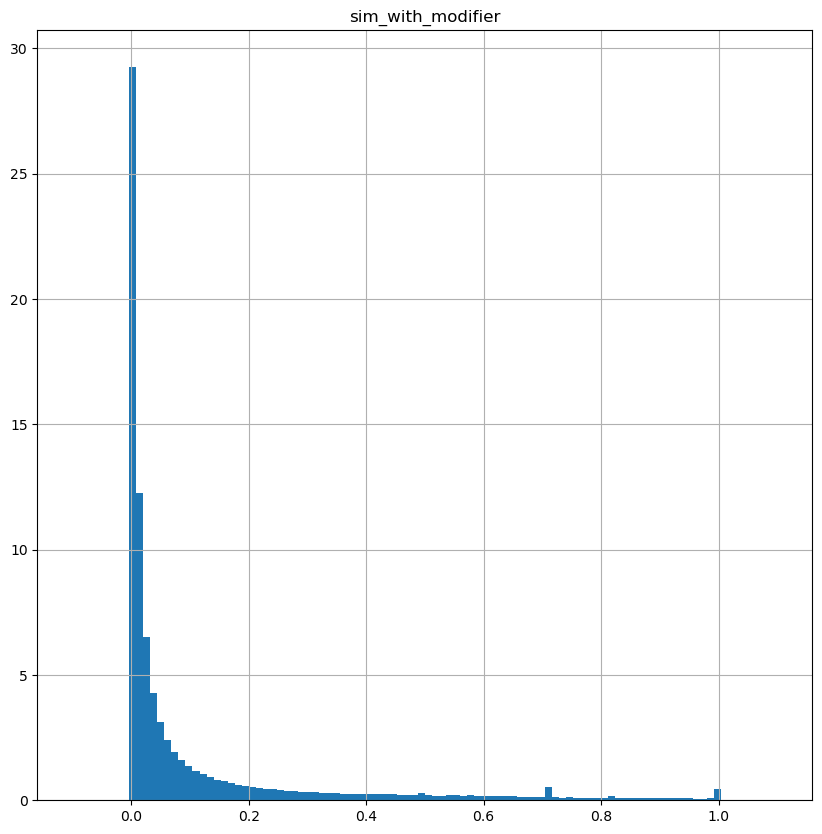

In [17]:
_=compound_modifier_sim.hist(column ='sim_with_modifier', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.1,1.1))

In [18]:
compound_modifier_sim.sim_with_modifier.describe()

count    4.421550e+07
mean     1.107455e-01
std      2.021887e-01
min      1.826735e-09
25%      3.874545e-03
50%      2.022150e-02
75%      1.017191e-01
max      1.000000e+00
Name: sim_with_modifier, dtype: float64

In [19]:
if args.temporal==0:
    
    compound_head_sim=pd.merge(compounds,heads,on=["head","context"])
    compound_head_sim['numerator']=compound_head_sim['comp_count']*compound_head_sim['head_count']
    compound_head_sim=compound_head_sim.groupby(['modifier','head'],observed=True)['numerator'].sum().to_frame()
    compound_head_sim=pd.merge(compound_head_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head"])
    compound_head_sim=pd.merge(compound_head_sim,head_denom.reset_index(),on=['head'])
    compound_head_sim['sim_with_head']=compound_head_sim['numerator']/(compound_head_sim['compound_denom']*compound_head_sim['head_denom'])
    compound_head_sim.set_index(['modifier','head'],inplace=True)
    compound_head_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)
else:
    compound_head_sim=pd.merge(compounds,heads,on=["head","context",'time'])
    compound_head_sim['numerator']=compound_head_sim['comp_count']*compound_head_sim['head_count']
    compound_head_sim=compound_head_sim.groupby(['modifier','head','time'],observed=True)['numerator'].sum().to_frame()
    compound_head_sim=pd.merge(compound_head_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head",'time'])
    compound_head_sim=pd.merge(compound_head_sim,head_denom.reset_index(),on=['head','time'])
    compound_head_sim['sim_with_head']=compound_head_sim['numerator']/(compound_head_sim['compound_denom']*compound_head_sim['head_denom'])
    compound_head_sim.set_index(['modifier','head','time'],inplace=True)
    compound_head_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)
compound_head_sim

head_denom  sim_with_head
modifier  head       time                            
a         a          1800  5553.943734       0.448261
air       a          1800  5553.943734       0.009670
alphabet  a          1800  5553.943734       0.523398
angle     a          1800  5553.943734       0.352555
anon      a          1800  5553.943734       0.002701
...                                ...            ...
zymomonas anaerobia  1980    17.000000       0.707107
                     1990     9.000000       0.707107
          anaerobium 1970    16.000000       1.000000
                     1980    17.000000       1.000000
zyrtec    zyrtec     2000    22.203603       0.410969

[44031879 rows x 2 columns]

In [20]:
compound_head_sim.sim_with_head.describe()

count    4.403188e+07
mean     9.175184e-02
std      1.800823e-01
min      1.629797e-09
25%      3.219562e-03
50%      1.652628e-02
75%      7.676081e-02
max      1.000000e+00
Name: sim_with_head, dtype: float64

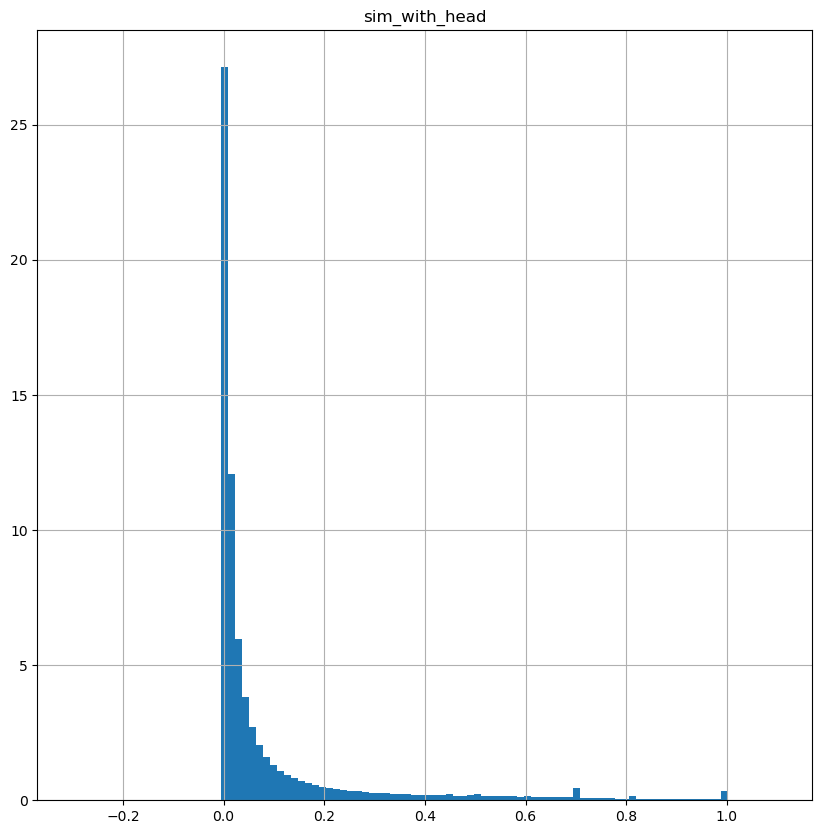

In [21]:
_=compound_head_sim.hist(column ='sim_with_head', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.3,1.1))

In [22]:
if args.temporal==0:
    
    constituent_sim=pd.merge(heads,compounds,on=["head","context"])
    #constituent_sim.drop('comp_count',axis=1,inplace=True)
    constituent_sim=pd.merge(constituent_sim,modifiers,on=["modifier","context"])
    constituent_sim['numerator']=constituent_sim['head_count']*constituent_sim['mod_count']
    constituent_sim=constituent_sim.groupby(['modifier','head'],observed=True)['numerator'].sum().to_frame()
    constituent_sim=pd.merge(constituent_sim.reset_index(),head_denom.reset_index(),on=["head"])
    constituent_sim=pd.merge(constituent_sim,modifier_denom.reset_index(),on=["modifier"])
    constituent_sim['sim_bw_constituents']=constituent_sim['numerator']/(constituent_sim['head_denom']*constituent_sim['modifier_denom'])
    constituent_sim.set_index(['modifier','head'],inplace=True)
    constituent_sim.drop(['numerator','modifier_denom','head_denom'],axis=1,inplace=True)
else:
    constituent_sim=pd.merge(heads,compounds,on=["head","context","time"])
    #constituent_sim.drop('comp_count',axis=1,inplace=True)
    constituent_sim=pd.merge(constituent_sim,modifiers,on=["modifier","context","time"])
    constituent_sim['numerator']=constituent_sim['head_count']*constituent_sim['mod_count']
    constituent_sim=constituent_sim.groupby(['modifier','head','time'],observed=True)['numerator'].sum().to_frame()
    constituent_sim=pd.merge(constituent_sim.reset_index(),head_denom.reset_index(),on=["head","time"])
    constituent_sim=pd.merge(constituent_sim,modifier_denom.reset_index(),on=["modifier","time"])
    constituent_sim['sim_bw_constituents']=constituent_sim['numerator']/(constituent_sim['head_denom']*constituent_sim['modifier_denom'])
    constituent_sim.set_index(['modifier','head','time'],inplace=True)
    constituent_sim.drop(['numerator','modifier_denom','head_denom'],axis=1,inplace=True)

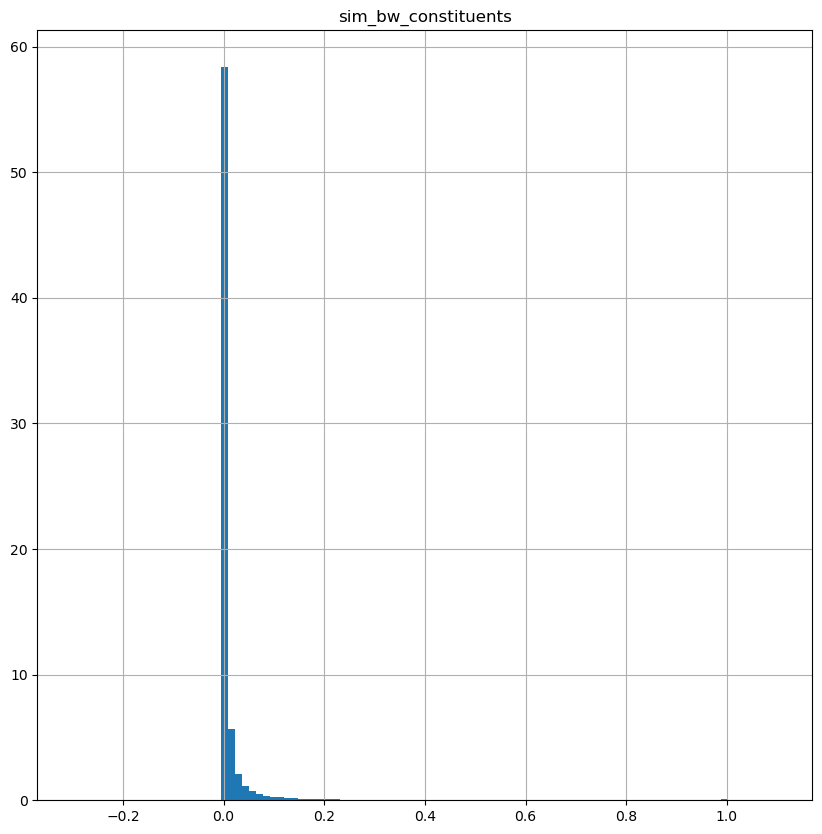

In [23]:
_=constituent_sim.hist(column ='sim_bw_constituents', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.3,1.1))

In [24]:
dfs = [XY,constituent_sim, compound_head_sim.sim_with_head, compound_modifier_sim.sim_with_modifier, information_feat,productivity]
compounds_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True), dfs)



if args.temporal!=0:
    compounds_final=pd.pivot_table(compounds_final.reset_index(), index=['modifier','head'], columns=['time'])

    #compounds_final.fillna(0,inplace=True)
    #compounds_final -= compounds_final.min()
    #compounds_final /= compounds_final.max()
    compounds_final_1=compounds_final.columns.get_level_values(0)
    compounds_final_2=compounds_final.columns.get_level_values(1)

    cur_year=0
    new_columns=[]
    for year in compounds_final_2:
        new_columns.append(str(year)+"_"+compounds_final_1[cur_year])
        cur_year+=1
    compounds_final.columns=new_columns


else:
    pass
    #compounds_final = reduce(lambda left,right: pd.merge(left,right,on=['modifier','head']), dfs)
    #compounds_final.drop(['head_denom','modifier_denom'],axis=1,inplace=True)
    #compounds_final.fillna(0,inplace=True)
    #compounds_final -= compounds_final.min()
    #compounds_final /= compounds_final.max()
compounds_final.reset_index(inplace=True)
compounds_final

,modifier,head,1800_freq,1810_freq,1820_freq,1830_freq,1840_freq,1850_freq,1860_freq,1870_freq,...,1920_sim_with_modifier,1930_sim_with_modifier,1940_sim_with_modifier,1950_sim_with_modifier,1960_sim_with_modifier,1970_sim_with_modifier,1980_sim_with_modifier,1990_sim_with_modifier,2000_sim_with_modifier,2010_sim_with_modifier
0,a,a,15.0,21.0,40.0,84.0,86.0,177.0,238.0,543.0,...,0.079617,0.070607,0.049468,0.143236,0.1335,0.203329,0.040877,0.042432,0.094454,0.182689
1,a,aas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.001057,0.000832,0.000706,NaN
2,a,abbreviation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.007114,NaN,NaN
3,a,abc,NaN,NaN,NaN,NaN,NaN,13.0,35.0,NaN,...,0.002238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003553
4,a,abstract,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034073,0.083412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8257035,zzyzx,foundation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.500000,NaN
8257036,zzz,corporation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.333374,NaN,NaN,NaN,NaN,0.345077,0.368584,0.330197,0.328290,0.345936
8257037,zzzadditional,research,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002787
8257038,zzzing,sound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.741620,0.741620,NaN,NaN,NaN,NaN,NaN,NaN,0.741620,0.741620


In [25]:
compounds_final=compounds_final.merge(compound_df,on=['modifier','head'])
compounds_final

,modifier,head,1800_freq,1810_freq,1820_freq,1830_freq,1840_freq,1850_freq,1860_freq,1870_freq,...,1980_sim_with_modifier,1990_sim_with_modifier,2000_sim_with_modifier,2010_sim_with_modifier,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std
0,academy,award,NaN,NaN,NaN,16.0,NaN,NaN,NaN,19.0,...,0.285357,0.253699,0.314602,0.366789,3.130400,1.632200,4.695700,1.473100,3.521700,1.473100
1,acid,test,NaN,NaN,NaN,56.0,169.0,463.0,675.0,1653.0,...,0.063840,0.031873,0.045497,0.041217,0.714286,1.097307,3.896552,1.241379,1.222222,1.257079
2,agony,aunt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.009848,0.021832,0.031188,0.146993,1.862069,1.224017,0.433333,0.558768,0.758621,0.857228
3,application,form,30.0,66.0,17.0,487.0,60.0,209.0,6832.0,310.0,...,0.148082,0.269063,0.364549,0.127550,4.766667,0.422953,4.862069,0.344828,4.800000,0.476095
4,arcade,game,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.242782,0.413108,0.257554,0.105571,3.760000,1.451400,4.680000,1.384400,3.800000,1.384400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,wedding,day,632.0,729.0,1331.0,1982.0,2459.0,3908.0,4046.0,5415.0,...,0.247646,0.231718,0.231094,0.205945,4.764700,0.562300,4.058800,0.242500,4.941200,0.242500
200,winter,solstice,1041.0,1699.0,2611.0,3977.0,4812.0,5540.0,4963.0,6407.0,...,0.169764,0.176826,0.172238,0.197127,5.000000,0.000000,4.681800,1.335500,4.545500,1.335500
201,word,painting,NaN,NaN,NaN,NaN,NaN,58.0,71.0,90.0,...,0.031485,0.024945,0.038078,0.052889,3.187500,1.558600,0.437500,1.310200,1.625000,1.310200
202,world,conference,NaN,NaN,26.0,NaN,48.0,NaN,NaN,58.0,...,0.027183,0.020155,0.017872,0.016808,3.875000,1.361300,4.291700,1.366700,3.958300,1.366700


In [26]:
if args.contextual:
    comp_str='CompoundAware'
else:
    comp_str='CompoundAgnostic'
    
if args.tag:
    tag_str='Tagged'
else:
    tag_str='UnTagged'

In [27]:
compounds_final.to_csv(f'{args.inputdir}/features_{comp_str}_{tag_str}_{str(args.temporal)}_{str(args.cutoff)}_2.csv',sep='\t',index=False)
